In [46]:
#numpy
import numpy as np

#chainer
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.utils import walker_alias
from chainer.datasets import split_dataset_random
from chainer import iterators
from chainer import training
from chainer.training import extensions

#その他
import collections
import matplotlib.pyplot as plt

In [47]:
class MyNet(chainer.Chain):
    '''Chainerお約束のネットワーク定義'''
    def __init__(self, n_out):
        super(MyNet, self).__init__()
        with self.init_scope():
            #3つの畳み込み層
            #2つの全結合層
            self.conv1 = L.Convolution2D(None, 32, 3, 3, 1)
            self.conv2 = L.Convolution2D(32, 64, 3, 3, 1)
            self.conv3 = L.Convolution2D(64, 128, 3, 3, 1)
            self.fc4 = L.Linear(None, 1000)
            self.fc5 = L.Linear(1000,n_out)
    
    def __call__(self, x):
        h = F.relu(self.conv1(x))#ReLU
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h
    
from chainer.datasets import cifar

def train(network_object, 
          batchsize=128, 
          gpu_id=0, 
          max_epoch=50,
          train_dataset=None,
          valid_dataset=None,
          test_dataset=None,
          postfix='',
          base_lr=0.01,
          lr_decay=None):
    '''訓練用の関数
    arg:
    network_object ネットワークのオブジェクト
    batchsize バッチサイズ
    gpu_id 使用するGPU ID
    max_epoch 学習を終了するエポック数
    train_dataset 訓練用のデータセット
    valid_dataset 評価用のデータセット
    test_dataset テスト用のデータセット
    base_lr 学習率の初期値
    lr_decay 学習率減衰のパラメータ
    '''
    #Dataset
    if train_dataset is None and valid_dataset is None and test_dataset is None:#全部からだったら
        train_val, test = cifar.get_cifar10()#データ取得(cifarより)
        train_size = int(len(train_val)*0.9)
        train, valid = split_dataset_random(train_val, train_size, seed=0)#9割train 1割vald
    else:
        train, valid, test = train_dataset, valid_dataset, test_dataset
        print(len(train))
        
    #Iterator
    train_iter = iterators.MultiprocessIterator(train, batchsize)
    valid_iter = iterators.MultiprocessIterator(valid, batchsize, False, False)
    
    #Model
    net = L.Classifier(network_object)
    
    #Optimizer
    optimizer = optimizers.MomentumSGD(lr=base_lr).setup(net)
    optimizer.add_hook(chainer.optimizer.WeightDecay(0.0005))
    
    #Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)
    
    #Trainer
    trainer = training.Trainer(
        updater=updater,
        stop_trigger=(max_epoch, 'epoch'),
        out='{}_cifar10_{}result'.format(network_object.__class__.__name__,postfix))
    
    #Trainer extensions
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.observe_lr())
    trainer.extend(extensions.Evaluator(valid_iter, net, device=gpu_id), name='val')
        #print
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy',
                                          'val/main/accuracy', 'elapsed_time', 'lr']))
        #plotting
    trainer.extend(extensions.PlotReport(['main/loss','val/main/loss'],
                                         x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'],
                                         x_key='epoch', file_name='accuracy.png'))
    if lr_decay is not None:
        trainer.extend(extensions.ExponentialShift('lr',0.1), trigger=lr_decay)
    trainer.run()
    del trainer
    
    #Evaluation
    test_iter = iterators.MultiprocessIterator(test, batchsize, False, False)
    test_evaluator = extensions.Evaluator(test_iter, net, device=gpu_id)
    results = test_evaluator()
    print('Test accuracy:', results['main/accuracy'])
    
    return net

In [48]:
net = train(MyNet(10),gpu_id=0)

epoch       main/loss   main/accuracy  val/main/accuracy  elapsed_time  lr        
1           1.93958     0.301469       0.395508           3.41792       0.01        
2           1.62127     0.420921       0.448047           6.44727       0.01        
3           1.4941      0.464076       0.491211           9.48177       0.01        
4           1.40106     0.496116       0.515234           12.5012       0.01        
5           1.33963     0.520589       0.516602           15.7634       0.01        
6           1.28335     0.539595       0.521289           19.0634       0.01        
7           1.2377      0.558093       0.545313           22.3556       0.01        
8           1.19355     0.573819       0.544922           25.6512       0.01        
9           1.14489     0.592485       0.568359           28.9638       0.01        
10          1.09773     0.610199       0.55957            32.0494       0.01        
11          1.05089     0.627086       0.571484           35.0745  

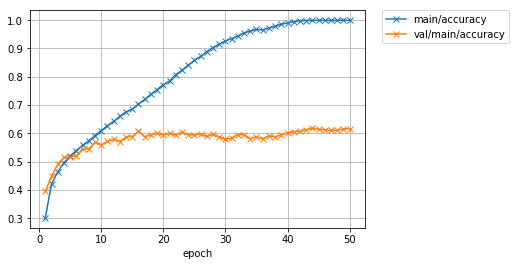

In [49]:
from IPython.display import Image
Image(filename='MyNet_cifar10_result/accuracy.png')

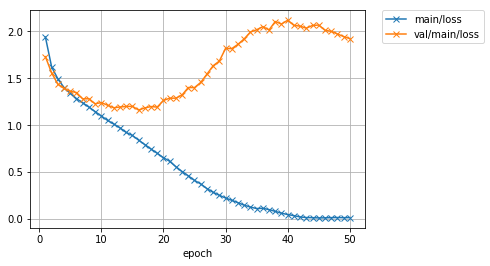

In [50]:
Image(filename='MyNet_cifar10_result/loss.png')

predicted_label: cat
answer: cat


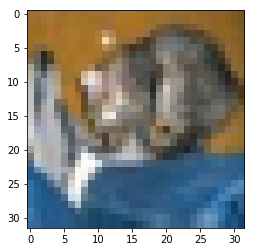

predicted_label: ship
answer: ship


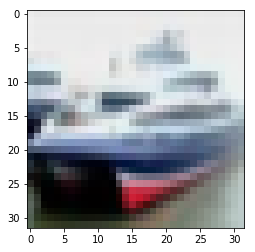

predicted_label: airplane
answer: ship


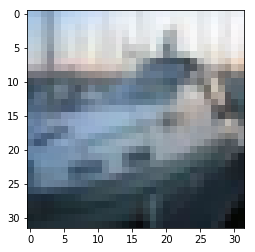

predicted_label: airplane
answer: airplane


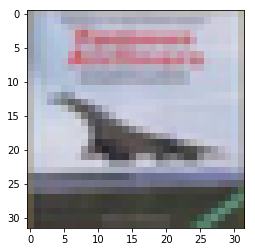

predicted_label: frog
answer: frog


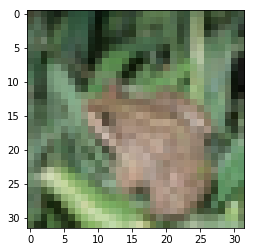

predicted_label: frog
answer: frog


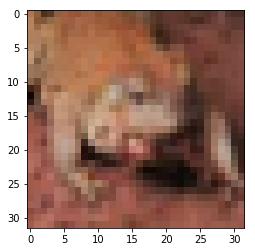

predicted_label: automobile
answer: automobile


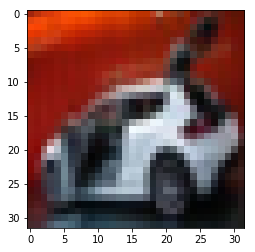

predicted_label: frog
answer: frog


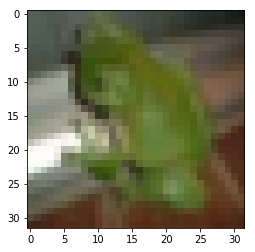

predicted_label: deer
answer: cat


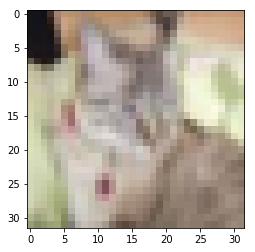

predicted_label: automobile
answer: automobile


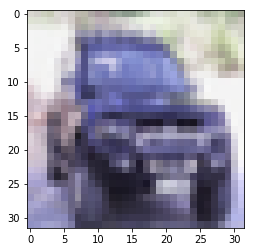

predicted_label: airplane
answer: airplane


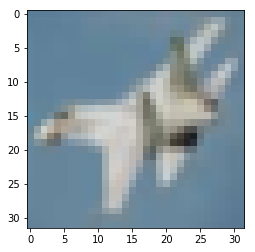

predicted_label: automobile
answer: truck


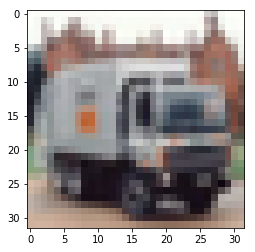

predicted_label: dog
answer: dog


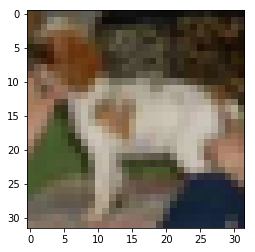

predicted_label: horse
answer: horse


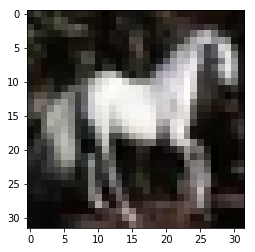

predicted_label: automobile
answer: truck


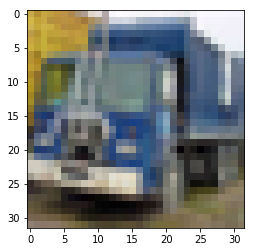

predicted_label: frog
answer: ship


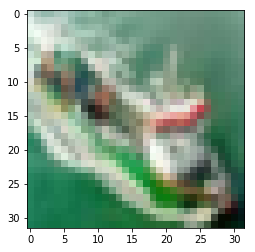

predicted_label: dog
answer: dog


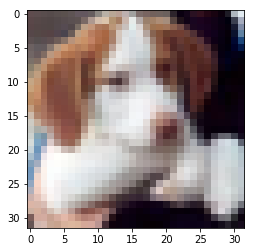

predicted_label: horse
answer: horse


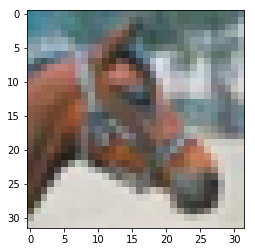

predicted_label: ship
answer: ship


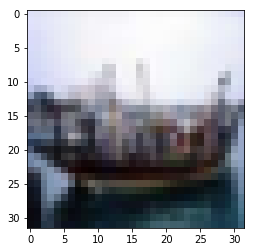

predicted_label: frog
answer: frog


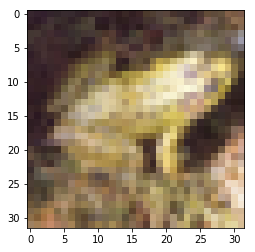

predicted_label: horse
answer: horse


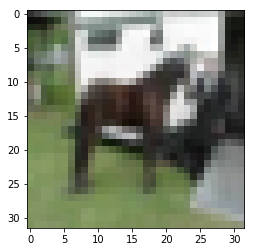

predicted_label: bird
answer: airplane


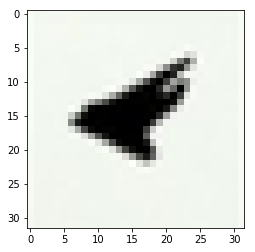

predicted_label: bird
answer: deer


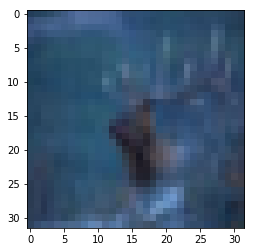

predicted_label: truck
answer: truck


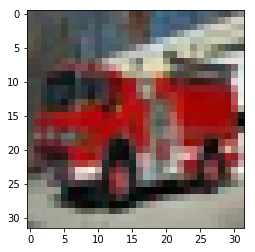

predicted_label: dog
answer: dog


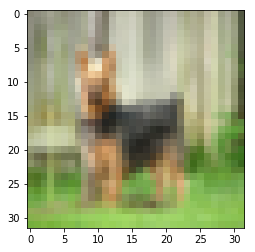

predicted_label: dog
answer: bird


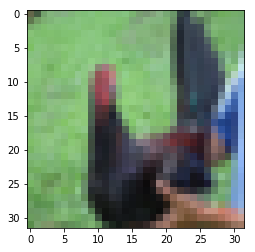

predicted_label: deer
answer: deer


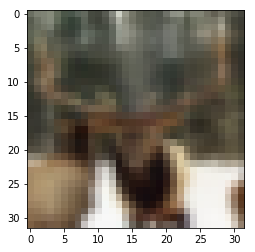

predicted_label: airplane
answer: airplane


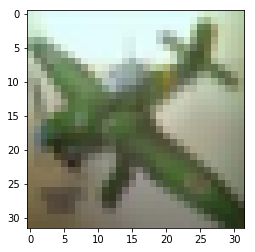

predicted_label: truck
answer: truck


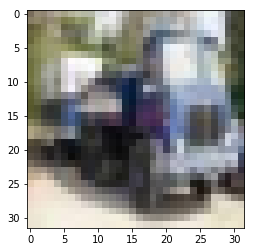

predicted_label: frog
answer: frog


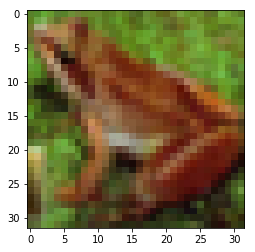

predicted_label: frog
answer: frog


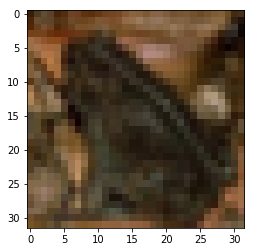

predicted_label: bird
answer: dog


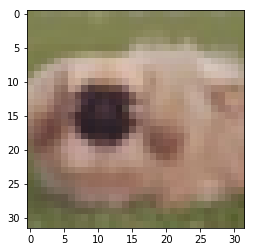

predicted_label: airplane
answer: deer


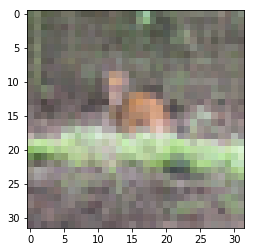

predicted_label: bird
answer: dog


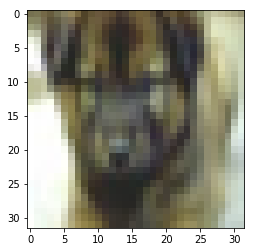

predicted_label: truck
answer: truck


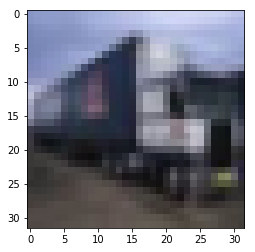

predicted_label: automobile
answer: bird


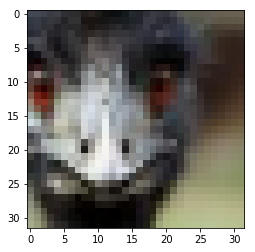

predicted_label: bird
answer: deer


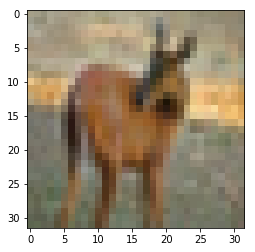

predicted_label: truck
answer: automobile


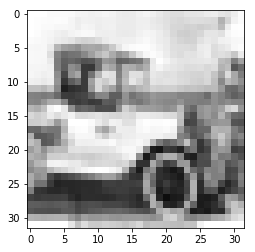

predicted_label: automobile
answer: truck


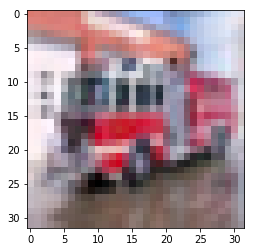

predicted_label: dog
answer: dog


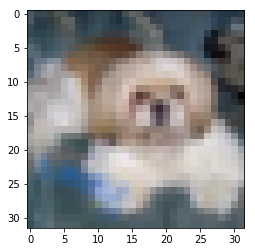

predicted_label: deer
answer: deer


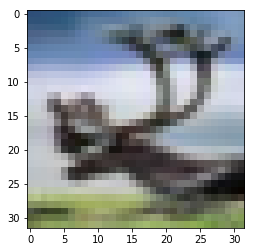

predicted_label: frog
answer: frog


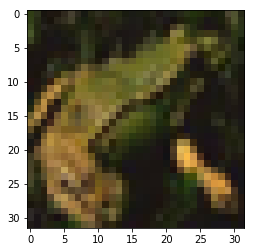

predicted_label: horse
answer: dog


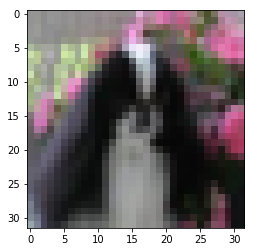

predicted_label: deer
answer: frog


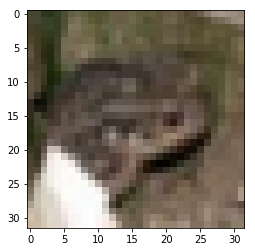

predicted_label: airplane
answer: airplane


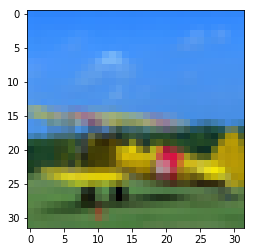

predicted_label: truck
answer: truck


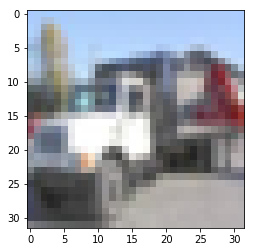

predicted_label: cat
answer: cat


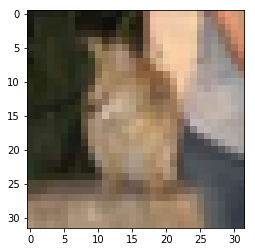

predicted_label: cat
answer: truck


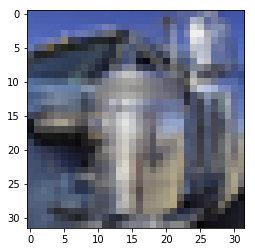

predicted_label: horse
answer: horse


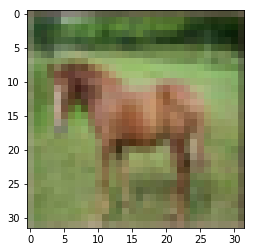

predicted_label: frog
answer: frog


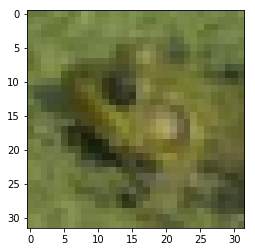

predicted_label: truck
answer: truck


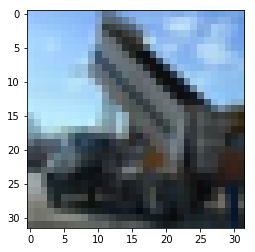

predicted_label: deer
answer: ship


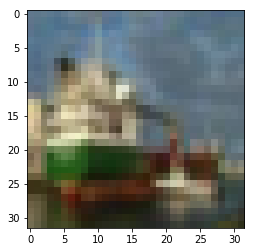

predicted_label: deer
answer: airplane


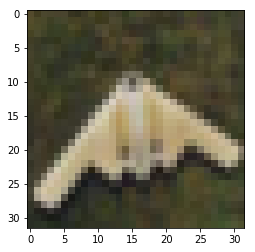

predicted_label: cat
answer: cat


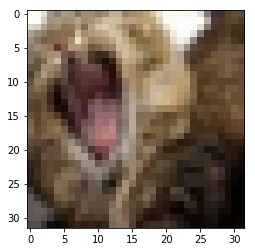

predicted_label: ship
answer: ship


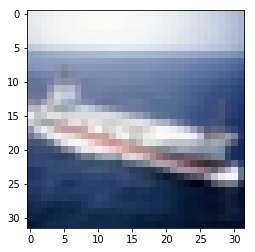

predicted_label: ship
answer: ship


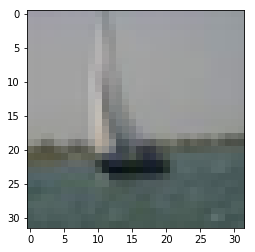

predicted_label: horse
answer: horse


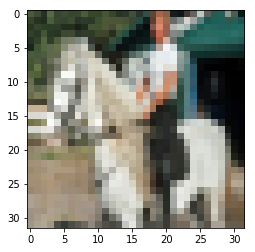

predicted_label: frog
answer: horse


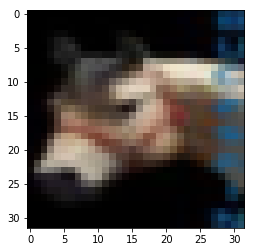

predicted_label: cat
answer: deer


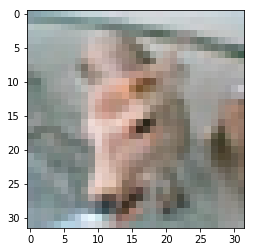

predicted_label: deer
answer: frog


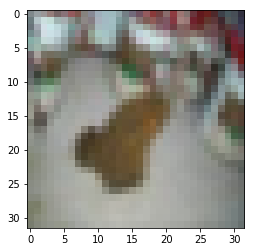

predicted_label: horse
answer: horse


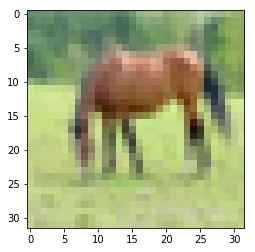

predicted_label: cat
answer: cat


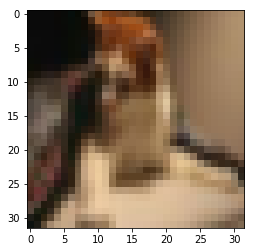

predicted_label: frog
answer: frog


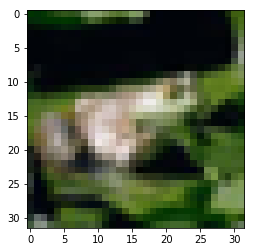

predicted_label: cat
answer: cat


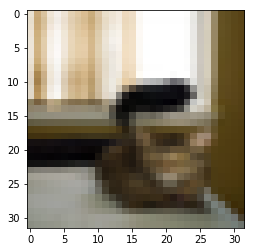

predicted_label: dog
answer: frog


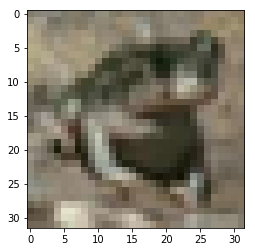

predicted_label: bird
answer: bird


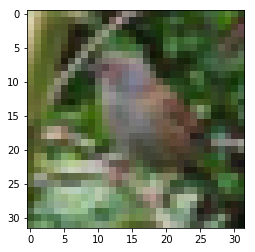

predicted_label: automobile
answer: automobile


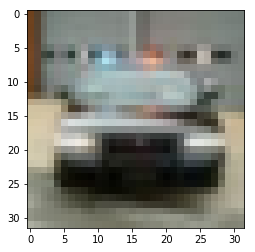

predicted_label: bird
answer: bird


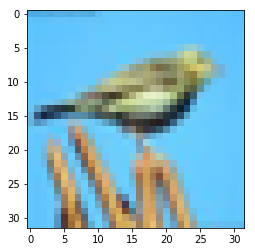

predicted_label: dog
answer: cat


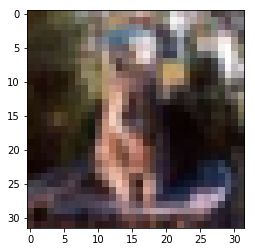

predicted_label: bird
answer: horse


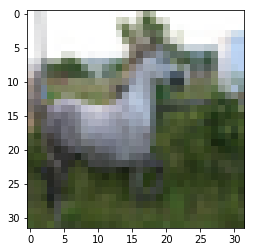

predicted_label: deer
answer: bird


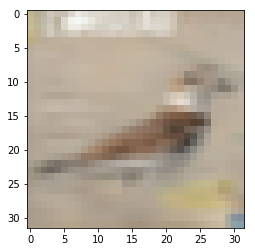

predicted_label: frog
answer: frog


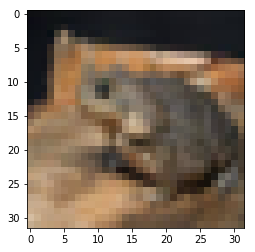

predicted_label: ship
answer: ship


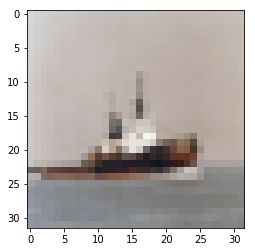

predicted_label: ship
answer: ship


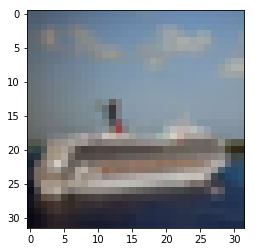

predicted_label: airplane
answer: airplane


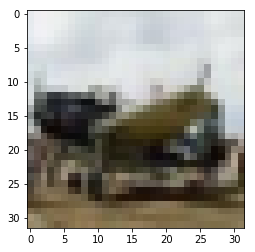

predicted_label: bird
answer: bird


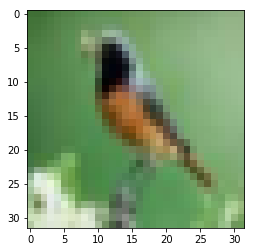

predicted_label: truck
answer: truck


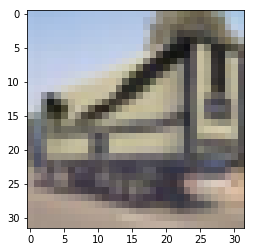

predicted_label: frog
answer: cat


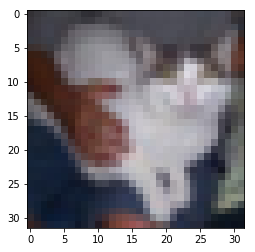

predicted_label: dog
answer: cat


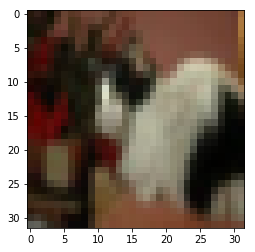

predicted_label: ship
answer: ship


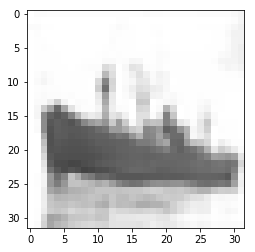

predicted_label: ship
answer: ship


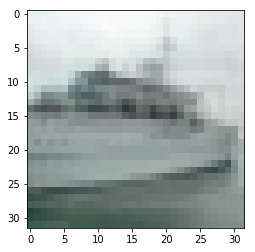

predicted_label: frog
answer: automobile


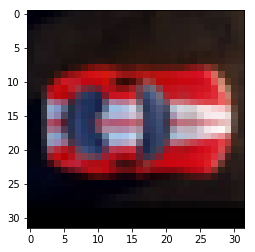

predicted_label: automobile
answer: automobile


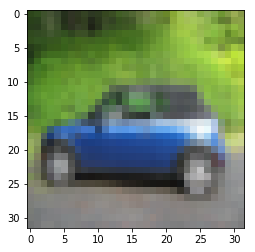

predicted_label: horse
answer: horse


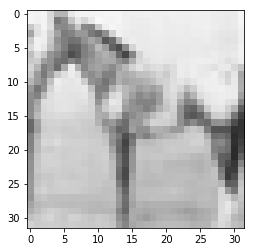

predicted_label: cat
answer: bird


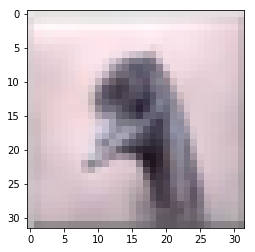

predicted_label: horse
answer: dog


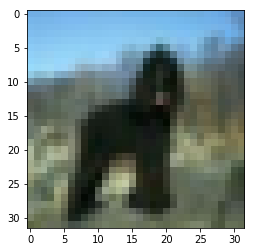

predicted_label: bird
answer: bird


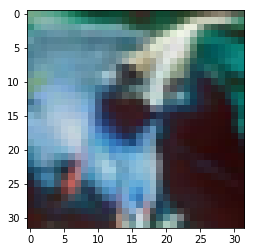

predicted_label: ship
answer: horse


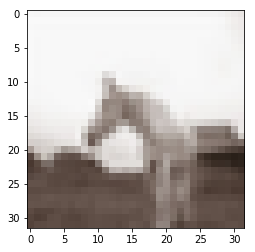

predicted_label: ship
answer: ship


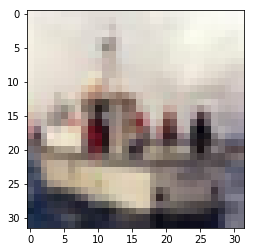

predicted_label: truck
answer: truck


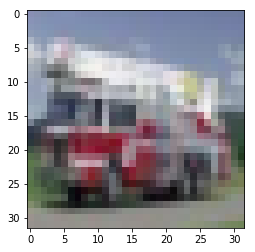

predicted_label: airplane
answer: airplane


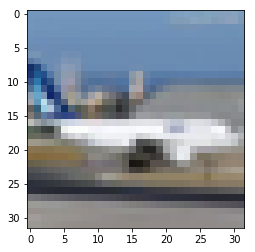

predicted_label: cat
answer: cat


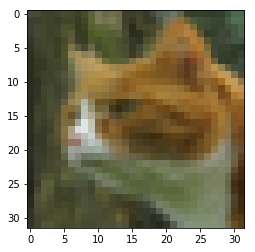

predicted_label: ship
answer: ship


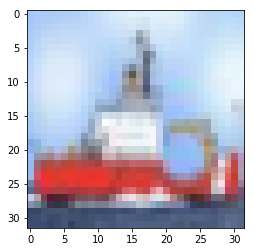

predicted_label: frog
answer: frog


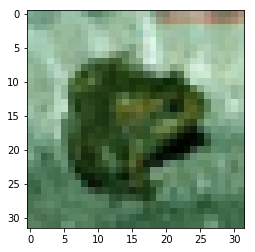

predicted_label: deer
answer: deer


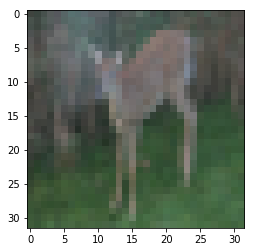

predicted_label: dog
answer: frog


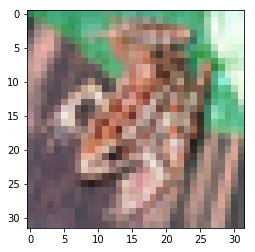

predicted_label: deer
answer: frog


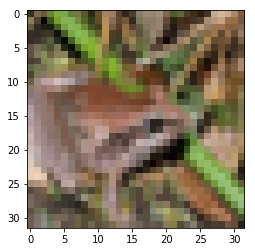

predicted_label: bird
answer: airplane


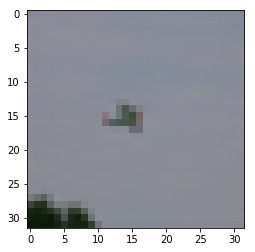

predicted_label: airplane
answer: airplane


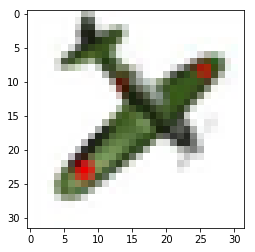

predicted_label: horse
answer: horse


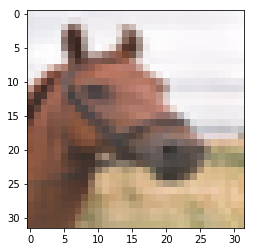

In [52]:
cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog',
             'frog', 'horse', 'ship' , 'truck']

def predict(net, image_id):
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    net.to_cpu()
    with chainer.using_config('train',False), chainer.using_config('enable_backdrop',False):
        y = net.predictor(x[None,...]).data.argmax(axis=1)[0]#推測
    print('predicted_label:', cls_names[y])
    print('answer:' ,cls_names[t])
    
    plt.imshow(x.transpose(1,2,0))
    plt.show()

for i in range(100):
    predict(net,i)